# Introduction
The aim of question 1 is to check if all “Safety Line data scientist daily tasks” are mastered, from processing raw data to model building.
Simulated flight signals representing fuel flow (in pound per second), altitude (in feet), wind (in knots) and speed (in km/h) are stored in the question1 folder of the archive in DataFrame format. Each dataframe stores signals in the following structure:
1.	indexes: time vector
2.	columns: number of flights
Dataframes can be read with pickle reader method, for exemple:
output = pd.read_pickle("signals_altitude.pkl")
For example, signals of the flight #44 are stored in the 44th column. 
 	 
 	 

Note that time vector can be different from one flight number to another.
Write a script or a notebook which contains all the step to answer below questions. 


# Question 1
Explain the data processing steps to select the best features and prepare them for the learning phase.

**Answer:** Due to inconsistent timestamps across the datasets, we cannot build a time series prediction model using the global data. Conceptually, it would not have had a lot of sense anyway. In long timestamp interspaces, current speed (or other flight parameters) are uncorrelated to future speed. They will mostly depend on the trajectory the flight.

Instead, a more practical approach is to this problem is to predict each local point using the other features available at that timestamp.

In a production environment, this type of model could be valuable for compensating for sensor failures. For example, if an altitude sensor malfunctions, our model could still estimate altitude based on the other available measurements.

**STRONG ASSUMPTION**: For the remainder of this analysis, we'll assume that all flights are performed by similar aircraft. Without this assumption, we would effectively have 100 separate regression problems, which wouldn't yield meaningful insights.



## Data loading

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

import matplotlib.pyplot as plt

# Load the data
altitude_df = pd.read_pickle("signals_altitude.pkl")
fuel_flow_df = pd.read_pickle("signals_fuel_flow.pkl")
speed_df = pd.read_pickle("signals_vitesse.pkl") 
wind_df = pd.read_pickle("signals_wind.pkl")

# Display basic information about the datasets
print("Altitude DataFrame shape:", altitude_df.shape)
print("Fuel Flow DataFrame shape:", fuel_flow_df.shape)
print("Speed DataFrame shape:", speed_df.shape)
print("Wind DataFrame shape:", wind_df.shape)


Altitude DataFrame shape: (40, 100)
Fuel Flow DataFrame shape: (40, 100)
Speed DataFrame shape: (40, 100)
Wind DataFrame shape: (40, 100)


## Data visualisation

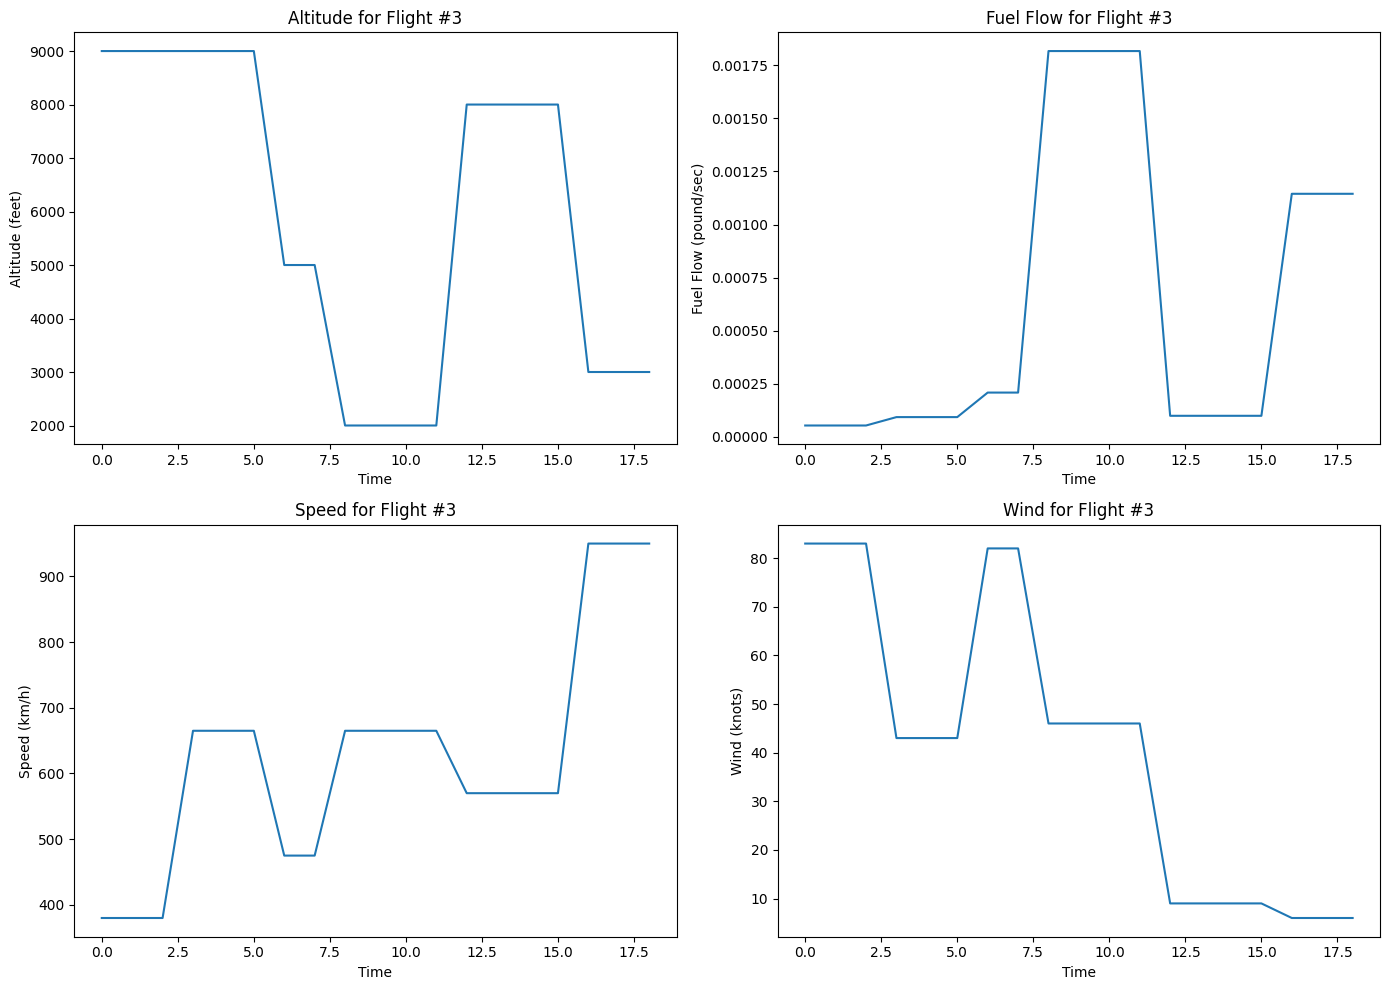

In [7]:
# Let's visualize data for a sample flight (e.g., flight #40)
flight_num = 3
plt.figure(figsize=(14, 10))

# Plot Altitude
plt.subplot(2, 2, 1)
plt.plot(altitude_df.index, altitude_df[flight_num])
plt.title(f'Altitude for Flight #{flight_num}')
plt.ylabel('Altitude (feet)')
plt.xlabel('Time')

# Plot Fuel Flow
plt.subplot(2, 2, 2)
plt.plot(fuel_flow_df.index, fuel_flow_df[flight_num])
plt.title(f'Fuel Flow for Flight #{flight_num}')
plt.ylabel('Fuel Flow (pound/sec)')
plt.xlabel('Time')

# Plot Speed
plt.subplot(2, 2, 3)
plt.plot(speed_df.index, speed_df[flight_num])
plt.title(f'Speed for Flight #{flight_num}')
plt.ylabel('Speed (km/h)')
plt.xlabel('Time')

# Plot Wind
plt.subplot(2, 2, 4)
plt.plot(wind_df.index, wind_df[flight_num])
plt.title(f'Wind for Flight #{flight_num}')
plt.ylabel('Wind (knots)')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

## DATA anomalie    
Our final objective is to aggregate all the values of the flight into a single dataset. Though, before to do this we need to ensure that all data given in the datasets are coherents. 
For this, we'll apply a basic filtering on all flies, to ensure that they have coherents data.

- We'll compute average value of altitude

## Preprocessing

In [ ]:
def aggregate_flight_data(flight_num):
    """
    Aggregates data for a specific flight number from all dataframes.
    Returns a dataframe with columns: altitude, fuel_flow, speed, wind
    """
    # Extract data for the specified flight
    altitude = altitude_df[flight_num].dropna().to_frame().rename(columns={flight_num: 'altitude'})
    fuel_flow = fuel_flow_df[flight_num].dropna().to_frame().rename(columns={flight_num: 'fuel_flow'})
    speed = speed_df[flight_num].dropna().to_frame().rename(columns={flight_num: 'speed'})
    wind = wind_df[flight_num].dropna().to_frame().rename(columns={flight_num: 'wind'})
    
    # Merge all dataframes on their indices (timestamps)
    # Start with altitude and merge the rest one by one
    merged_df = altitude.merge(fuel_flow, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.merge(speed, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.merge(wind, left_index=True, right_index=True, how='inner')
    
    # Add flight number as a column
    merged_df['flight_num'] = flight_num
    
    # Reset index to make timestamp a column
    merged_df = merged_df.reset_index().rename(columns={'index': 'timestamp'})
    
    return merged_df

# Create a dictionary to store the aggregated data for each flight
flight_data = {}
for flight in range(altitude_df.shape[1]):
    flight_data[flight] = aggregate_flight_data(flight)

# Combine all flights into one large dataframe
all_flights_df = pd.concat(flight_data.values(), ignore_index=True)

# Convert columns to numeric (where possible)
for feature in ['altitude', 'speed', 'wind']:
    all_flights_df[feature] = pd.to_numeric(clean_df[feature], errors='coerce')

# Check the result
print(f"Combined dataframe shape: {clean_df.shape}")
print("\nSome random samples:")
all_flights_df.sample(10)

Combined dataframe shape: (2105, 6)

Some random samples:


,timestamp,altitude,fuel_flow,speed,wind,flight_num
839,5,4000.0,0.000197,285.0,80.0,40
2101,19,1000.0,0.009518,855.0,18.0,99
722,12,2000.0,0.000522,190.0,17.0,34
1912,14,2000.0,0.000791,285.0,65.0,90
1329,1,2000.0,0.000774,285.0,16.0,63
1253,2,2000.0,0.001038,380.0,93.0,60
1805,14,8000.0,0.000131,760.0,16.0,85
708,16,10000.0,0.000041,380.0,57.0,33
611,8,3000.0,0.000118,95.0,93.0,29
1416,4,3000.0,0.000118,95.0,60.0,67


## DATA anomaly   
Our final objective is to aggregate all the values of the flight into a single dataset. Though, before to do this we need to ensure that all data given in the datasets are coherents. 
For this, we'll apply a basic filtering on all flies, to ensure that they have coherents data.

- We'll compute average value of altitude, fuel_flow, speed, and wind, across all datasets, and their std, and range.
- All flight which countains absurd value will be removed. A value will be considered "absurd" if it is outside the range mean -+ 5 std, or it contains negative value


ALTITUDE STATISTICS:
Mean: 5844.33
Std: 5768.48
Min: -50.00
Max: 72000.00
Threshold low (mean - 5*std): -22998.09
Threshold high (mean + 5*std): 34686.74

FUEL_FLOW STATISTICS:
Mean: 18.18
Std: 196.24
Min: -80.00
Max: 5000.00
Threshold low (mean - 5*std): -963.02
Threshold high (mean + 5*std): 999.39

SPEED STATISTICS:
Mean: 1237.84
Std: 32685.46
Min: -15852.00
Max: 1500000.00
Threshold low (mean - 5*std): -162189.47
Threshold high (mean + 5*std): 164665.15

WIND STATISTICS:
Mean: 50.51
Std: 29.24
Min: 1.00
Max: 100.00
Threshold low (mean - 5*std): -95.71
Threshold high (mean + 5*std): 196.72

ANOMALIES IN ALTITUDE:
Number of flights with anomalies: 4
Example anomalous flights: [ 4 30 44 45]
     flight_num  altitude
78            4     -50.0
626          30   70000.0
923          44   50095.0
924          44   50095.0
925          44   50095.0

ANOMALIES IN FUEL_FLOW:
Number of flights with anomalies: 3
Example anomalous flights: [ 4 12 24]
     flight_num fuel_flow
78            4  

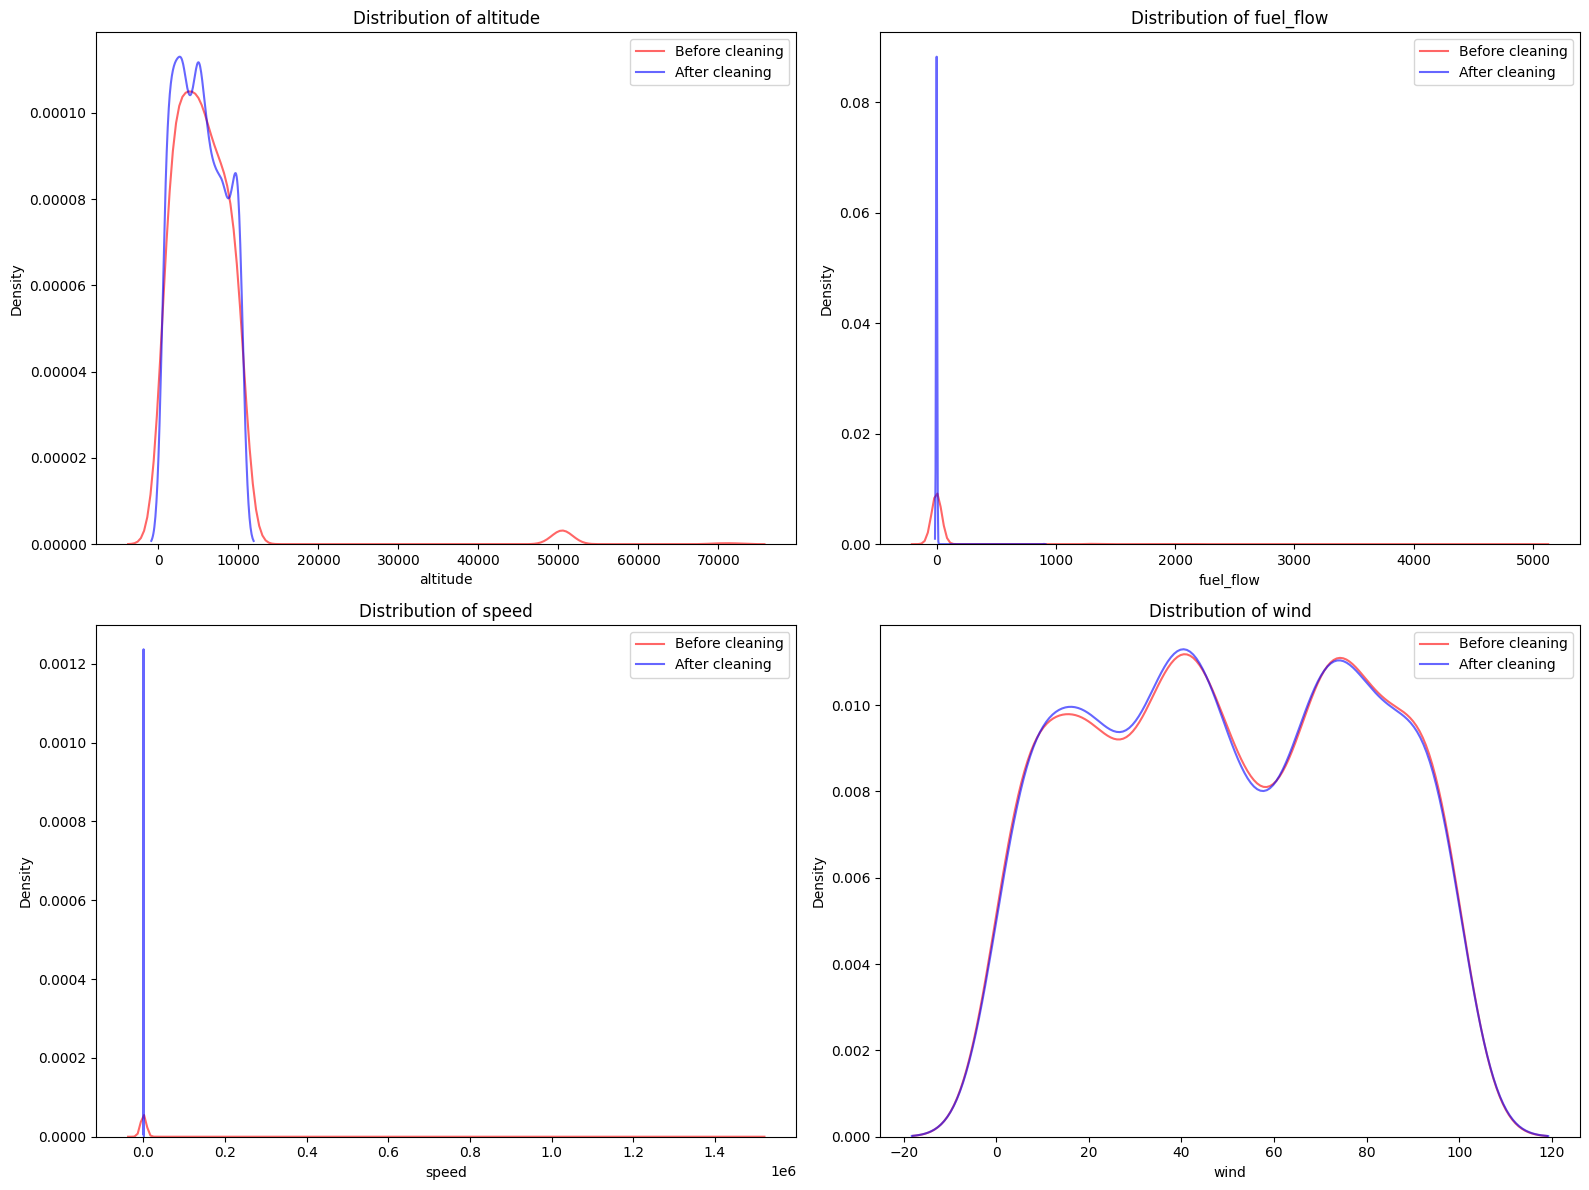

In [15]:
# Calculate statistics for each feature across all flights
stats = {}
features = ['altitude', 'fuel_flow', 'speed', 'wind']

for feature in features:
    stats[feature] = {
        'mean': all_flights_df[feature].mean(),
        'std': all_flights_df[feature].std(),
        'min': all_flights_df[feature].min(),
        'max': all_flights_df[feature].max(),
        'threshold_low': all_flights_df[feature].mean() - 5 * all_flights_df[feature].std(),
        'threshold_high': all_flights_df[feature].mean() + 5 * all_flights_df[feature].std()
    }
    
    print(f"\n{feature.upper()} STATISTICS:")
    print(f"Mean: {stats[feature]['mean']:.2f}")
    print(f"Std: {stats[feature]['std']:.2f}")
    print(f"Min: {stats[feature]['min']:.2f}")
    print(f"Max: {stats[feature]['max']:.2f}")
    print(f"Threshold low (mean - 5*std): {stats[feature]['threshold_low']:.2f}")
    print(f"Threshold high (mean + 5*std): {stats[feature]['threshold_high']:.2f}")

# Identify anomalous flights
anomalous_flights = set()

for feature in features:
    # Find flights with values outside the thresholds or negative values
    anomaly_mask = ((all_flights_df[feature] < stats[feature]['threshold_low']) | 
                    (all_flights_df[feature] > stats[feature]['threshold_high']) | 
                    (all_flights_df[feature] < 0))
    
    # Get the flight numbers with anomalies
    flights_with_anomalies = all_flights_df.loc[anomaly_mask, 'flight_num'].unique()
    anomalous_flights.update(flights_with_anomalies)
    
    print(f"\nANOMALIES IN {feature.upper()}:")
    print(f"Number of flights with anomalies: {len(flights_with_anomalies)}")
    
    if len(flights_with_anomalies) > 0:
        print("Example anomalous flights:", flights_with_anomalies[:5])
        
        # Display some example anomalous values
        example_anomalies = all_flights_df[all_flights_df['flight_num'].isin(flights_with_anomalies[:3]) & anomaly_mask]
        print(example_anomalies[['flight_num', feature]].head())

# Filter out all data from anomalous flights
clean_df = all_flights_df[~all_flights_df['flight_num'].isin(anomalous_flights)]

print(f"\nTotal number of anomalous flights: {len(anomalous_flights)} out of {all_flights_df['flight_num'].nunique()}")

print(f"Original dataset shape: {all_flights_df.shape}")
print(f"Cleaned dataset shape: {clean_df.shape}")
print(f"Removed {len(all_flights_df) - len(clean_df)} rows in total ({((len(all_flights_df) - len(clean_df))/len(all_flights_df))*100:.2f}% of data)")

# Visualize distribution of features before cleaning
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    
    # Before cleaning
    sns.kdeplot(all_flights_df[feature], label='Before cleaning', color='red', alpha=0.6)
    
    # After cleaning
    sns.kdeplot(clean_df[feature], label='After cleaning', color='blue', alpha=0.6)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()




## Selecting most pertinent features

C:\Users\33642\AppData\Local\Temp\ipykernel_2736\2764741423.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[target] = pd.to_numeric(clean_df[target], errors='coerce')



=== Model using without_flight_num ===
Baseline model with all features - RMSE: 0.0003, R²: 0.9824
Without altitude - RMSE: 8.2964, R²: -13509479.6154, Impact: 8.2961
Without speed - RMSE: 0.0009, R²: 0.8337, Impact: 0.0006
Without wind - RMSE: 4.6572, R²: -4257080.2683, Impact: 4.6569

=== Model using with_flight_num ===
Baseline model with all features - RMSE: 0.0001, R²: 0.9965
Without altitude - RMSE: 0.0012, R²: 0.7171, Impact: 0.0011
Without speed - RMSE: 0.0007, R²: 0.8898, Impact: 0.0006
Without wind - RMSE: 0.0002, R²: 0.9927, Impact: 0.0001
Without flight_num - RMSE: 0.0003, R²: 0.9824, Impact: 0.0002

=== Comparison of Feature Sets ===
Without flight_num - RMSE: 0.0003, R²: 0.9824
With flight_num - RMSE: 0.0001, R²: 0.9965
Improvement with flight_num: 0.0002 RMSE


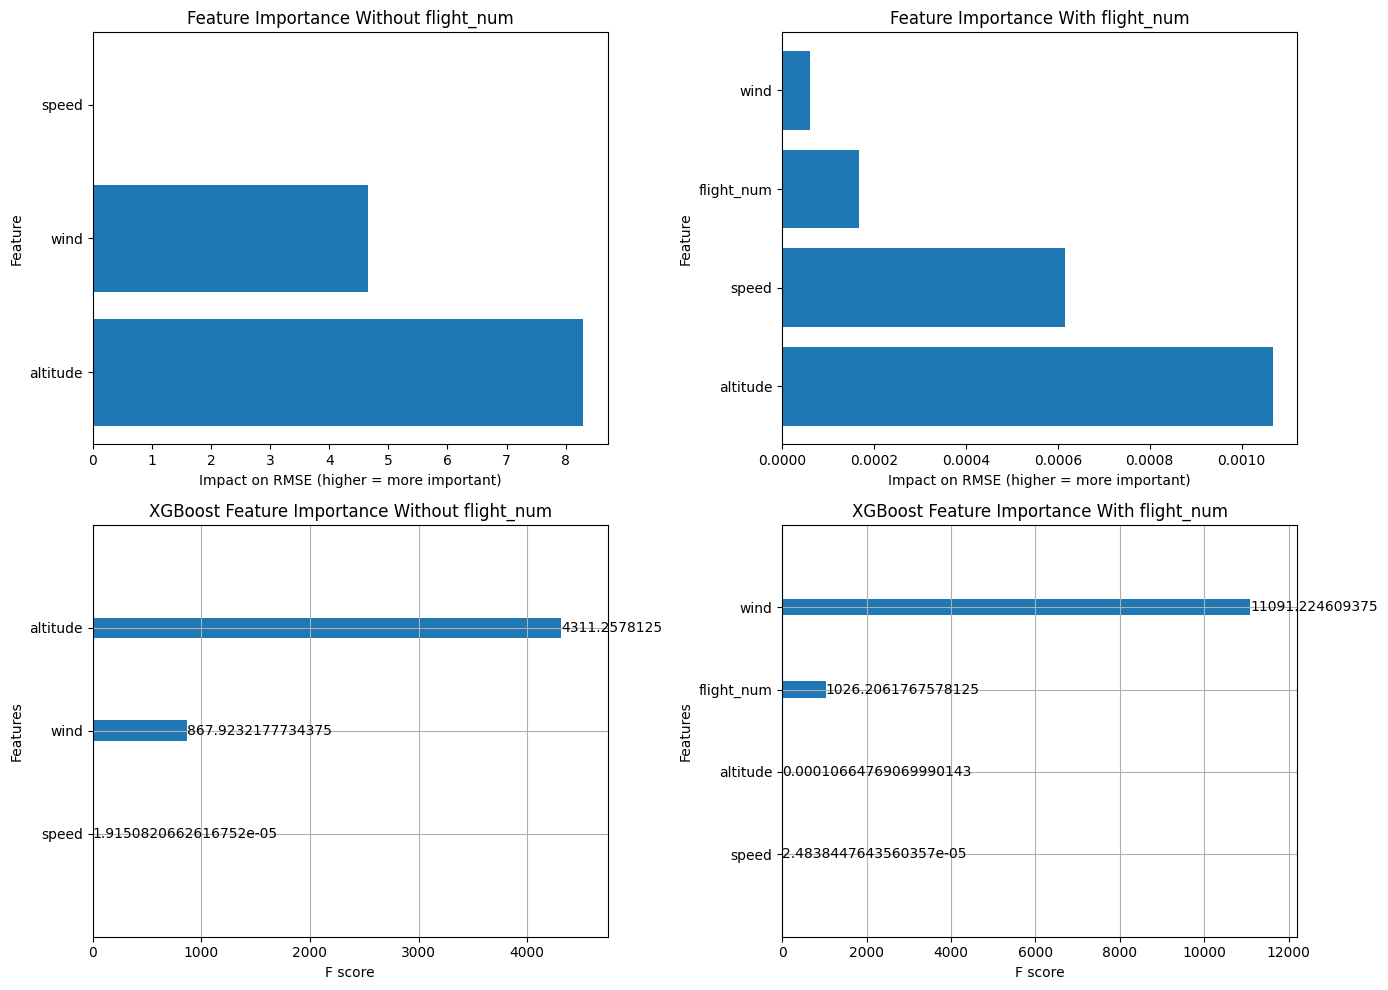

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target variable for predicting fuel flow
base_features = ['altitude', 'speed', 'wind']
target = 'fuel_flow'
random_seed = 1

# Convert target to numeric (in case it's stored as string/object)
clean_df[target] = pd.to_numeric(clean_df[target], errors='coerce')

# Check for and handle any NaN values
if clean_df[target].isna().any():
    print(f"Warning: {clean_df[target].isna().sum()} NaN values found after conversion and have been dropped")
    clean_df = clean_df.dropna(subset=[target])

# Define two feature sets: one with flight_num and one without
feature_sets = {
    'without_flight_num': base_features,
    'with_flight_num': base_features + ['flight_num']
}

# Initialize a dictionary to store results for each feature set
results = {}

# Run the analysis for each feature set
for set_name, features in feature_sets.items():
    print(f"\n=== Model using {set_name} ===")
    
    # Baseline model with all features in this set
    X = clean_df[features]
    y = clean_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    
    # Train XGBoost model with all features from this set
    baseline_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_seed)
    baseline_model.fit(X_train, y_train)
    baseline_preds = baseline_model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
    baseline_r2 = r2_score(y_test, baseline_preds)
    
    print(f"Baseline model with all features - RMSE: {baseline_rmse:.4f}, R²: {baseline_r2:.4f}")
    
    # Store the baseline model and metrics
    results[set_name] = {
        'model': baseline_model,
        'rmse': baseline_rmse,
        'r2': baseline_r2,
        'feature_importance': {}
    }
    
    # Feature importance based on leave-one-out approach
    for feature in features:
        # Use all features except the current one
        remaining_features = [f for f in features if f != feature]
        X_reduced = clean_df[remaining_features]
        
        X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=random_seed)
        
        # Train model without the current feature
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_seed)
        model.fit(X_train_red, y_train)
        preds = model.predict(X_test_red)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        
        # Higher impact (worse metrics without this feature) means more important feature
        impact = rmse - baseline_rmse
        results[set_name]['feature_importance'][feature] = {
            'rmse': rmse,
            'r2': r2,
            'impact': impact
        }
        
        print(f"Without {feature} - RMSE: {rmse:.4f}, R²: {r2:.4f}, Impact: {impact:.4f}")

# Compare the overall performance of both feature sets
print("\n=== Comparison of Feature Sets ===")
print(f"Without flight_num - RMSE: {results['without_flight_num']['rmse']:.4f}, R²: {results['without_flight_num']['r2']:.4f}")
print(f"With flight_num - RMSE: {results['with_flight_num']['rmse']:.4f}, R²: {results['with_flight_num']['r2']:.4f}")
print(f"Improvement with flight_num: {results['without_flight_num']['rmse'] - results['with_flight_num']['rmse']:.4f} RMSE")

# Visualize feature importance for both models
plt.figure(figsize=(14, 10))

# First model: without flight_num
plt.subplot(2, 2, 1)
sorted_features = sorted(results['without_flight_num']['feature_importance'].items(), key=lambda x: x[1]['impact'], reverse=True)
features_list = [item[0] for item in sorted_features]
impact_values = [item[1]['impact'] for item in sorted_features]
plt.barh(features_list, impact_values)
plt.xlabel('Impact on RMSE (higher = more important)')
plt.ylabel('Feature')
plt.title('Feature Importance Without flight_num')

# Second model: with flight_num
plt.subplot(2, 2, 2)
sorted_features = sorted(results['with_flight_num']['feature_importance'].items(), key=lambda x: x[1]['impact'], reverse=True)
features_list = [item[0] for item in sorted_features]
impact_values = [item[1]['impact'] for item in sorted_features]
plt.barh(features_list, impact_values)
plt.xlabel('Impact on RMSE (higher = more important)')
plt.ylabel('Feature')
plt.title('Feature Importance With flight_num')

# XGBoost feature importance: without flight_num
plt.subplot(2, 2, 3)
xgb.plot_importance(results['without_flight_num']['model'], ax=plt.gca(), importance_type='gain')
plt.title('XGBoost Feature Importance Without flight_num')

# XGBoost feature importance: with flight_num
plt.subplot(2, 2, 4)
xgb.plot_importance(results['with_flight_num']['model'], ax=plt.gca(), importance_type='gain')
plt.title('XGBoost Feature Importance With flight_num')

plt.tight_layout()
plt.show()

## Conclusions

To estimate the importance of each feature in predicting fuel flow, we trained an XGBoost regressor model using all relevant variables. We then employed a one-against-the-other method, iteratively removing one feature from the dataset, training a new regressor each time, and comparing the impact of each feature's removal on the overall performance. Additionally, we used the XGBoost plot_importance function, which measures the average improvement a feature brings to the decision tree splits.

An unexpected finding was the significance of the flight number as a predictor variable, seemingly contradicting the initial assumption that all planes share similar performance characteristics. This might be due to the relatively small datasets associated with individual flights, some of which had as few as 20-30 data points with similar altitude and speed. It is highly probable that the model is capturing other parameters implicitly linked to the flight number, given these limited datasets. This issue of spurious correlations may be mitigated in datasets from longer flight durations.

Beyond this anomaly, altitude and wind stand out as significantly more important than the speed to predict the fuel consommation. The method employed to estimate a feature's influence can cause variations in its importance. For instance, wind might appear as either the most important feature or the least. In the one-against-the-other method, a variable with low apparent importance but not correlated to the rest of the dataset could have a strong impact because its value cannot be inferred from others.


# Question 2
2.	Build a fuel flow model as a function of:
- Effective speed range of data
- Constant altitude of 8000 ft
- Why not wind speed?


Data points in altitude range (7800, 8200): 168
Model performance - RMSE: 0.000044, R²: -0.028817
altitude importance: 0.000000
speed importance: 0.000000
wind importance: 0.000000


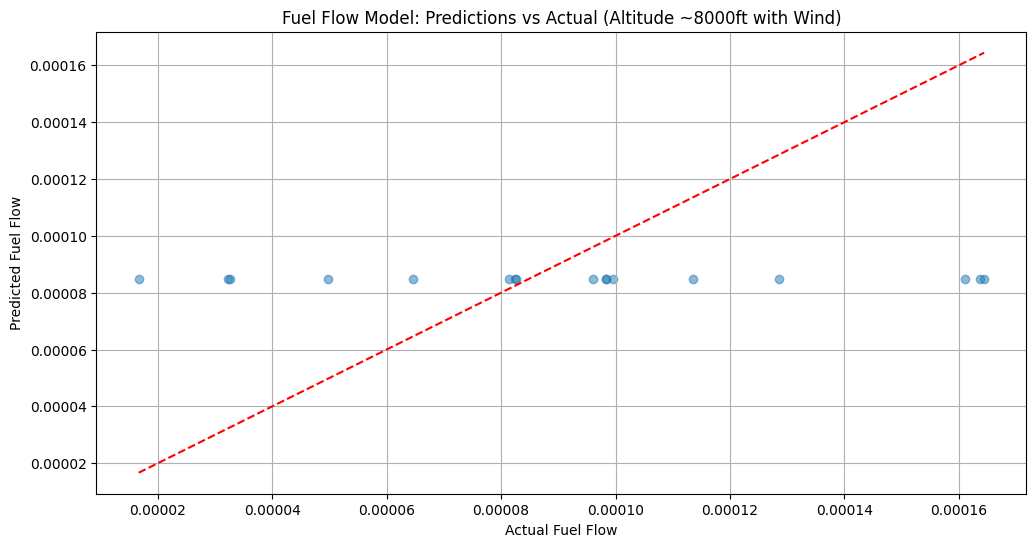

In [24]:
def build_fuel_flow_model(altitude_range=(7800, 8200), speed_range=None, include_wind=True):
    """
    Build a fuel flow model based on filtered data for specified altitude and speed ranges.
    
    Parameters:
    altitude_range: Tuple of (min_altitude, max_altitude)
    speed_range: Tuple of (min_speed, max_speed), if None, use all speed data
    include_wind: Boolean to include wind as a feature
    
    Returns:
    model, X_test, y_test, performance metrics
    """
    # Filter data based on altitude range
    altitude_filter = (clean_df['altitude'] >= altitude_range[0]) & (clean_df['altitude'] <= altitude_range[1])
    filtered_df = clean_df[altitude_filter].copy()
    
    print(f"Data points in altitude range {altitude_range}: {filtered_df.shape[0]}")
    
    # Filter by speed range if provided
    if speed_range is not None:
        speed_filter = (filtered_df['speed'] >= speed_range[0]) & (filtered_df['speed'] <= speed_range[1])
        filtered_df = filtered_df[speed_filter]
        print(f"Data points in speed range {speed_range}: {filtered_df.shape[0]}")
    
    # Define features based on whether to include wind
    features = ['altitude', 'speed']
    if include_wind:
        features.append('wind')
    
    # Prepare data for modeling
    X = filtered_df[features]
    y = filtered_df['fuel_flow']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    
    # Train model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model performance - RMSE: {rmse:.6f}, R²: {r2:.6f}")
    
    # Feature importance
    importance = model.feature_importances_
    for i, feature in enumerate(features):
        print(f"{feature} importance: {importance[i]:.6f}")
    
    # Return model and evaluation data
    results = {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'rmse': rmse,
        'r2': r2,
        'features': features
    }
    
    return results

# Test the function with different configurations
# 1. Constant altitude around 8000ft with all speeds and wind
altitude_8000_with_wind = build_fuel_flow_model(altitude_range=(7800, 8200), include_wind=True)

# Visualize predictions vs actual values for the model with wind
plt.figure(figsize=(12, 6))
plt.scatter(altitude_8000_with_wind['y_test'], altitude_8000_with_wind['y_pred'], alpha=0.5)
plt.plot([min(altitude_8000_with_wind['y_test']), max(altitude_8000_with_wind['y_test'])], 
         [min(altitude_8000_with_wind['y_test']), max(altitude_8000_with_wind['y_test'])], 'r--')
plt.xlabel('Actual Fuel Flow')
plt.ylabel('Predicted Fuel Flow')
plt.title('Fuel Flow Model: Predictions vs Actual (Altitude ~8000ft with Wind)')
plt.grid(True)
plt.show()


## Question 3
3.	Build fuel flow model as a function of:
- [0-15000] ft altitude range
- constant speed of 665 km/h
- Why not wind speed?


Data points in altitude range (0, 15000): 1945
Data points in speed range (655, 675): 170
Model performance - RMSE: 0.000079, R²: 0.997834
altitude importance: 1.000000
speed importance: 0.000000
wind importance: 0.000000


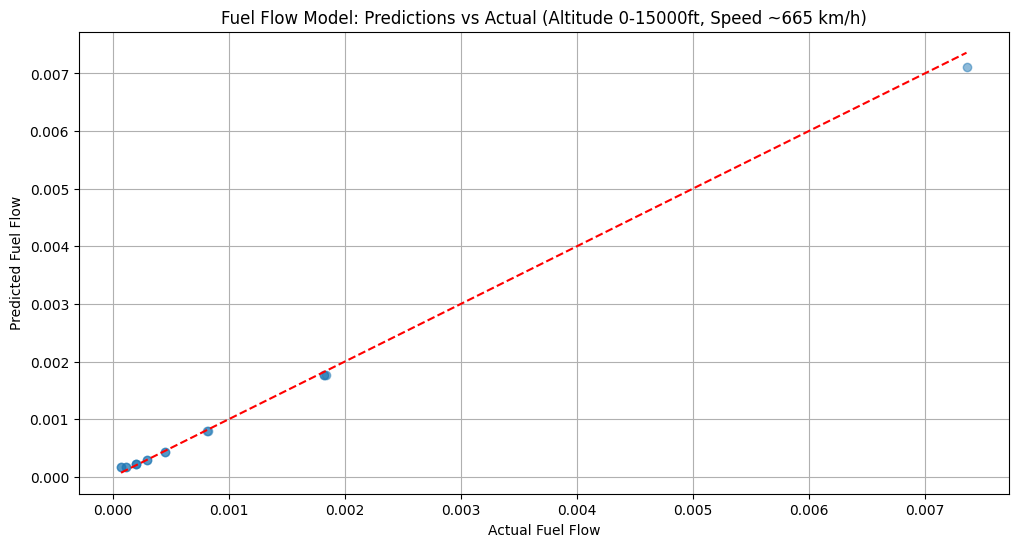

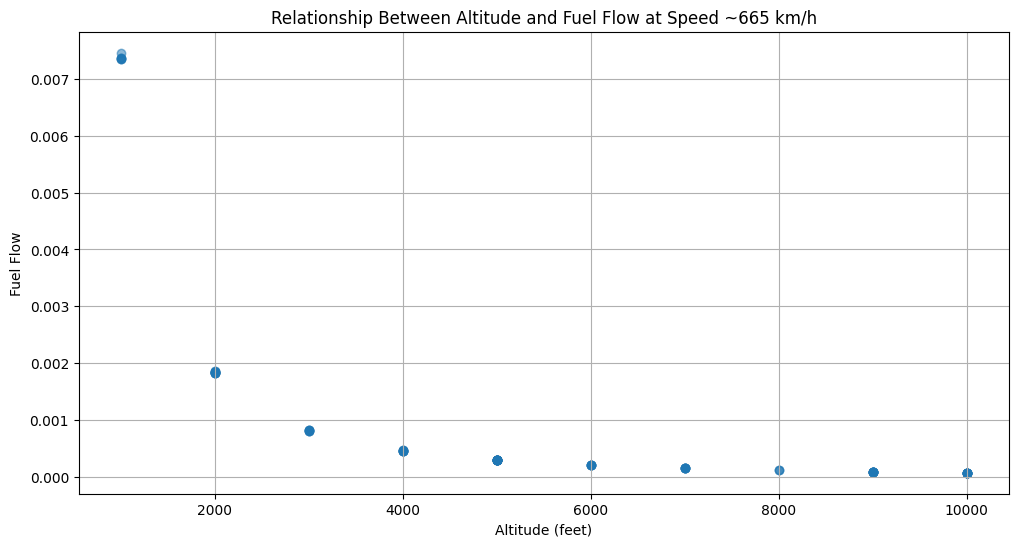

In [27]:
# Build the model for Question 3: 0-15000 ft altitude range with constant speed around 665 km/h
altitude_0_15000_speed_665 = build_fuel_flow_model(
    altitude_range=(0, 15000),
    speed_range=(655, 675),  # Speed range around 665 km/h
    include_wind=True
)

# Visualize predictions vs actual values for the model
plt.figure(figsize=(12, 6))
plt.scatter(altitude_0_15000_speed_665['y_test'], altitude_0_15000_speed_665['y_pred'], alpha=0.5)
plt.plot([min(altitude_0_15000_speed_665['y_test']), max(altitude_0_15000_speed_665['y_test'])], 
         [min(altitude_0_15000_speed_665['y_test']), max(altitude_0_15000_speed_665['y_test'])], 'r--')
plt.xlabel('Actual Fuel Flow')
plt.ylabel('Predicted Fuel Flow')
plt.title('Fuel Flow Model: Predictions vs Actual (Altitude 0-15000ft, Speed ~665 km/h)')
plt.grid(True)
plt.show()

# Visualize the relationship between altitude and fuel flow at constant speed
altitude_feature_data = clean_df[(clean_df['speed'] >= 655) & (clean_df['speed'] <= 675)]

plt.figure(figsize=(12, 6))
plt.scatter(altitude_feature_data['altitude'], altitude_feature_data['fuel_flow'], alpha=0.3)
plt.xlabel('Altitude (feet)')
plt.ylabel('Fuel Flow')
plt.title('Relationship Between Altitude and Fuel Flow at Speed ~665 km/h')
plt.grid(True)
plt.show()


# Question 4 (bonus)

This question has already been treated as part of the idenfitifations of important features.